## 1. 分析目標

- 專案目標：探討跨平台文章分類模型的適應能力與效果
- 訓練資料：以 Dcard 文章作為模型訓練資料
- 測試資料：應用於
    - 性質相似的社群平台：PTT
    - 性質差異較大的新聞媒體：聯合新聞網

- 重點：
    - 模型在不同平台與語境下的分類表現
    - 文本風格與內容類型差異對模型效果的影響
    - 分析分類準確度與表現落差背後的原因

In [2]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

In [3]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

## 2. 文字前處理
`dcard_merged.csv`裡面包含了要分析的 dcard 資料。
- 版別：美食、研究所、股票
- 時間範圍：2025/01/01-2025/02/22
- 工作流程平台搜尋/排除關鍵字：無

首先我們先看文集的基本資料，並做文集前處理。

In [ ]:
dcard = pd.read_csv("dataset2/dcard_merged.csv")  # 匯資料
dcard = dcard.rename(columns={'boardID': 'artCatagory'})
dcard.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/stock/p/257746054,2025-01-13 12:00:00,#分享 台積電法說前5大重點：成長動能與先進製程布局,\n台積電作為全球半導體製造領域的領導者，其每季法說會都吸引投資人、分析師及產業人士高度關注...,stock,1,ian_money,M,Ian編的理財筆記💸
1,2,Dcard,https://www.dcard.tw/f/stock/p/257763144,2025-01-15 13:55:51,#分享 1/15 晚上21:30 美國CPI公布2.9 ％🎉台指期噴發至+360點,\n1/15 晚上21:30 美國CPI公布2.9 ％\n附合預期\n台指期噴發至+360點...,stock,1,sckaofutures,M,期貨俠高玩
2,3,Dcard,https://www.dcard.tw/f/stock/p/257763102,2025-01-15 13:50:21,#標的 亞光3019，12月 合併營收21.45億元，創近3個月以來新高營收表現亮眼；數據利...,NaN,stock,1,jing7515,F,靜


In [23]:
# 看看有幾篇文章
print(f"number of posts: {dcard.shape[0]}")
print(f"date range: {(dcard['artDate'].min(), dcard['artDate'].max())}")
print(f"category: \n{dcard['artCatagory'].value_counts()}")

number of posts: 6262
date range: ('2025-01-01 01:00:04', '2025-02-22 17:36:07')
category: 
artCatagory
stock              2165
graduate_school    2093
food               2004
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

利用問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句，最後設定會去除結尾的空白符號。

In [24]:
# 過濾 nan 的資料
dcard = dcard.dropna(subset=['artTitle'])
dcard = dcard.dropna(subset=['artContent'])
# 移除網址格式
dcard["artContent"] = dcard.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
dcard["artTitle"] = dcard["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
dcard["artContent"] = dcard.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
dcard["artTitle"] = dcard["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
dcard.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/stock/p/257746054,2025-01-13 12:00:00,分享台積電法說前大重點成長動能與先進製程布局,台積電作為全球半導體製造領域的領導者其每季法說會都吸引投資人分析師及產業人士高度關注本次法說...,stock,1,ian_money,M,Ian編的理財筆記💸
1,2,Dcard,https://www.dcard.tw/f/stock/p/257763144,2025-01-15 13:55:51,分享晚上美國公布台指期噴發至點,晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,stock,1,sckaofutures,M,期貨俠高玩
3,4,Dcard,https://www.dcard.tw/f/stock/p/257763489,2025-01-15 14:33:09,標的明日的,再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責近期波動大...,stock,1,sodayu99,F,只是個新手


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [25]:
# 留下 content
dcard["content"] = dcard["artTitle"] + dcard["artContent"]
dcard = dcard[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
dcard.head()

,content,artUrl,artCatagory
0,分享台積電法說前大重點成長動能與先進製程布局台積電作為全球半導體製造領域的領導者其每季法說會...,https://www.dcard.tw/f/stock/p/257746054,stock
1,分享晚上美國公布台指期噴發至點晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,https://www.dcard.tw/f/stock/p/257763144,stock
3,標的明日的再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責...,https://www.dcard.tw/f/stock/p/257763489,stock
4,分享股癌看我獨自升級官感股市近況挖礦機相關故事股癌筆記分享贊助贊助看我獨自升級官感我獨自升級...,https://www.dcard.tw/f/stock/p/257763520,stock
5,分享對上櫃指數及中小型個股的看法大家好我是威力今天想要來分享我對上櫃指數的看法因為我主要是交...,https://www.dcard.tw/f/stock/p/257747161,stock


In [26]:
# 看看有幾篇文章
print(f"total docs: {dcard.shape[0]}")


total docs: 5963


### 2.2 斷詞

In [27]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [28]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [29]:
dcard["words"] = dcard["content"].apply(getToken).map(" ".join)
dcard.head()

Building prefix dict from /Users/zhangxuanwen/Desktop/社媒_hw2/dict/dict.txt.big ...
Loading model from cache /var/folders/t3/8gvdpyx92m196npgpq1v2_5w0000gn/T/jieba.ub5dbb3fe1acc419a0574c6fe805113a4.cache


Loading model cost 1.614 seconds.
Prefix dict has been built successfully.


,content,artUrl,artCatagory,words
0,分享台積電法說前大重點成長動能與先進製程布局台積電作為全球半導體製造領域的領導者其每季法說會...,https://www.dcard.tw/f/stock/p/257746054,stock,分享 台積 電法 重點 成長 動能 先進 製程 布局 台積 電作 全球 半導體 製造 領域 ...
1,分享晚上美國公布台指期噴發至點晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,https://www.dcard.tw/f/stock/p/257763144,stock,分享 晚上 美國 公布 指期 噴發 至點 晚上 美國 公布 附合 預期 指期 噴發 點明 早...
3,標的明日的再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責...,https://www.dcard.tw/f/stock/p/257763489,stock,標的 明日 再加 一張 一日 行情 券多 一張 多一分 快樂 做空 推薦 做多此 購買 建議...
4,分享股癌看我獨自升級官感股市近況挖礦機相關故事股癌筆記分享贊助贊助看我獨自升級官感我獨自升級...,https://www.dcard.tw/f/stock/p/257763520,stock,分享 股癌 升級 官感 股市 近況 挖礦 相關 故事 股癌 筆記 分享 贊助 贊助 升級 官...
5,分享對上櫃指數及中小型個股的看法大家好我是威力今天想要來分享我對上櫃指數的看法因為我主要是交...,https://www.dcard.tw/f/stock/p/257747161,stock,分享 上櫃 指數 中小型 個股 看法 威力 今天 要來 分享 上櫃 指數 看法 主要 交易 ...


### 2.3 資料集基本檢視

檢視資料內容

In [30]:
print(f"total posts: {len(dcard['artUrl'].unique())}")
print(f"category: \n{dcard['artCatagory'].value_counts()}")


total posts: 5963
category: 
artCatagory
graduate_school    2074
stock              2039
food               1850
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [32]:
data = dcard
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

3660    跨考 化學 請益 目前 大三 應屆 中字 園藝 系系排 左右 推甄 應該 無望 決定 補習 ...
5834    圖多文 山區 平價 美食 超強 咖喱 大小 景美 港式 木柵 韓式 餐廳 山區 跑跳 三年 ...
1403               分享 配息 變少 這次 配息 縮水 一點 覺得 可惜 哭哭 領到 覺得 可惜
5422    年夜飯 轉眼 除夕 過去 一年 依舊 忙碌 充實 希望 未來 日子 能夠 平安 順利 菜飯 ...
3033               台聯 清大 材料 起跳 如題 知道 聽說 請問 板上 大哥 大姐 這是 真的
Name: words, dtype: object
3660    graduate_school
5834               food
1403              stock
5422               food
3033    graduate_school
Name: artCatagory, dtype: object


In [33]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
graduate_school    34.781150
stock              34.194198
food               31.024652
Name: proportion, dtype: float64

train percentage :
artCatagory
graduate_school    34.595113
stock              34.163872
food               31.241016
Name: proportion, dtype: float64

test percentage :
artCatagory
graduate_school    35.215204
stock              34.264952
food               30.519843
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集

模型訓練範例: logistic regression + cv tokenizer

In [34]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [35]:
X_train.head()

3660    跨考 化學 請益 目前 大三 應屆 中字 園藝 系系排 左右 推甄 應該 無望 決定 補習 ...
5834    圖多文 山區 平價 美食 超強 咖喱 大小 景美 港式 木柵 韓式 餐廳 山區 跑跳 三年 ...
1403               分享 配息 變少 這次 配息 縮水 一點 覺得 可惜 哭哭 領到 覺得 可惜
5422    年夜飯 轉眼 除夕 過去 一年 依舊 忙碌 充實 希望 未來 日子 能夠 平安 順利 菜飯 ...
3033               台聯 清大 材料 起跳 如題 知道 聽說 請問 板上 大哥 大姐 這是 真的
Name: words, dtype: object

In [36]:
vec_train = vectorizer.fit_transform(X_train)
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一下,一些,一份,一個月,一半,一口,一堆,一天,一定,一家,...,高雄,高點,鮭魚,鮮奶,鮮奶油,麻煩,黃金,黑糖,點了,點收
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(4174, 1000)
(1789, 1000)


In [38]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [39]:
clf.classes_

array(['food', 'graduate_school', 'stock'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [40]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['stock' 'food' 'stock' 'graduate_school' 'stock' 'stock'
 'graduate_school' 'food' 'food' 'graduate_school']


觀察看看模型輸出的類別機率

In [41]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(1789, 3)


array([0.00438824, 0.01914344, 0.97646832])

可以看到類別3的機率為0.97646832

### 3.4 模型評估

In [42]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           food       0.95      0.93      0.94       546
graduate_school       0.93      0.95      0.94       630
          stock       0.98      0.97      0.97       613

       accuracy                           0.95      1789
      macro avg       0.95      0.95      0.95      1789
   weighted avg       0.95      0.95      0.95      1789



輸出混淆矩陣

In [43]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[508,  29,   9],
       [ 23, 601,   6],
       [  3,  18, 592]])

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'food'),
  Text(0, 1.5, 'graduate_school'),
  Text(0, 2.5, 'stock')])

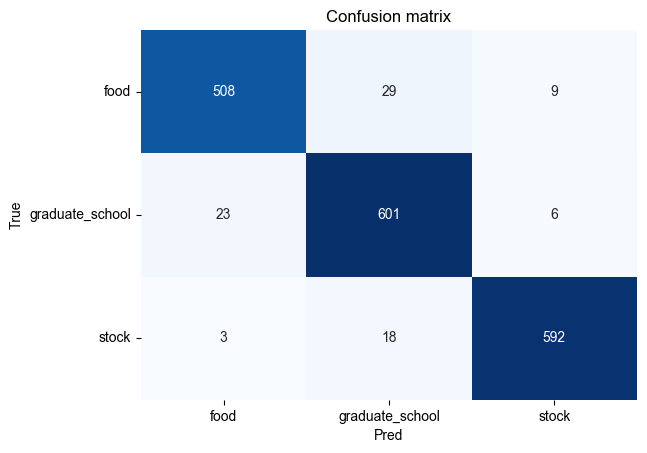

In [44]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 TF-IDF

改使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果。

In [45]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一下,一些,一份,一個月,一半,一口,一堆,一天,一定,一家,...,高雄,高點,鮭魚,鮮奶,鮮奶油,麻煩,黃金,黑糖,點了,點收
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069221,0.000000,0.106303,0.0,0.0,0.0,0.113683,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,0.042031,0.101794,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4170,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4171,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4172,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           food       0.97      0.94      0.96       546
graduate_school       0.94      0.97      0.96       630
          stock       0.99      0.98      0.98       613

       accuracy                           0.97      1789
      macro avg       0.97      0.96      0.97      1789
   weighted avg       0.97      0.97      0.97      1789



效果有好一點點，但沒有差很多。

### 3.5 CV

cross_validate：

- 返回多種指標的結果，包括 f1_macro、recall_macro 和 precision_macro，並能返回每折訓練和測試的時間、模型等詳細信息。

- 更適合用於綜合評估模型的性能並返回模型本身。

In [47]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.06500697, 0.05370712, 0.11947393, 0.23986316, 0.06078506]),
 'score_time': array([0.01742697, 0.02046895, 0.04373407, 0.03105783, 0.01663923]),
 'test_f1_macro': array([0.97345261, 0.96621372, 0.96137289, 0.96970215, 0.96495797]),
 'test_precision_macro': array([0.97456491, 0.96627654, 0.96125229, 0.97025107, 0.96550513]),
 'test_recall_macro': array([0.97282808, 0.96615514, 0.96154153, 0.96932756, 0.96459048])}


cross_val_predict：

- 返回每一折的預測標籤，用來後續生成分類報告（classification_report）。

- 適用於需要比較預測結果的情況。

In [48]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

                 precision    recall  f1-score   support

           food       0.97      0.95      0.96      1304
graduate_school       0.95      0.97      0.96      1444
          stock       0.98      0.99      0.99      1426

       accuracy                           0.97      4174
      macro avg       0.97      0.97      0.97      4174
   weighted avg       0.97      0.97      0.97      4174



## 4. 比較不同模型效果

In [49]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

因為TF-IDF的效果好一點，所以我們選擇使用TF-IDF來實作後面的模型。

                 precision    recall  f1-score   support

           food       0.97      0.95      0.96      1304
graduate_school       0.95      0.97      0.96      1444
          stock       0.98      0.99      0.99      1426

       accuracy                           0.97      4174
      macro avg       0.97      0.97      0.97      4174
   weighted avg       0.97      0.97      0.97      4174



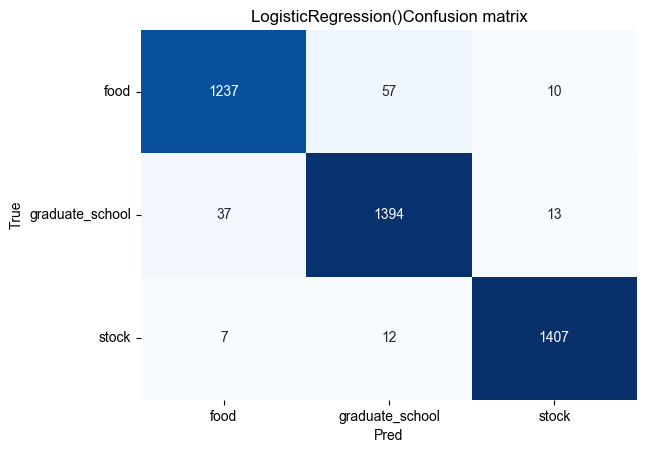

In [50]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

輸出：LogisticRegression、DecisionTree、SVC、RandomForest的各項檢測指標

now training: clf_logistic
                 precision    recall  f1-score   support

           food       0.97      0.95      0.96      1304
graduate_school       0.95      0.97      0.96      1444
          stock       0.98      0.99      0.99      1426

       accuracy                           0.97      4174
      macro avg       0.97      0.97      0.97      4174
   weighted avg       0.97      0.97      0.97      4174

now training: clf_dtree
                 precision    recall  f1-score   support

           food       0.85      0.91      0.88      1304
graduate_school       0.92      0.86      0.89      1444
          stock       0.94      0.93      0.93      1426

       accuracy                           0.90      4174
      macro avg       0.90      0.90      0.90      4174
   weighted avg       0.90      0.90      0.90      4174

now training: clf_svm
                 precision    recall  f1-score   support

           food       0.95      0.95      0.95      1304
graduate

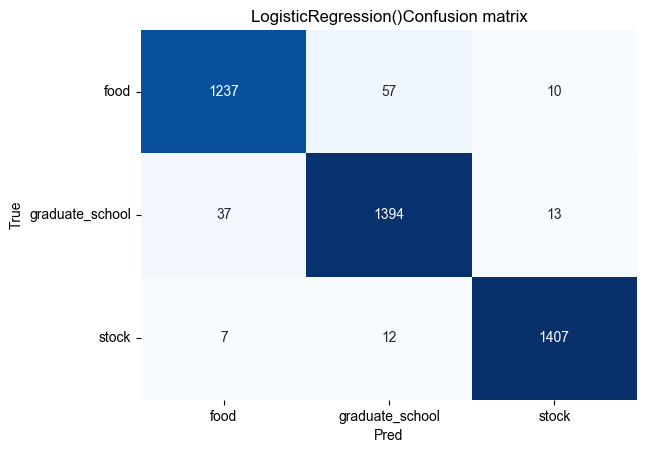

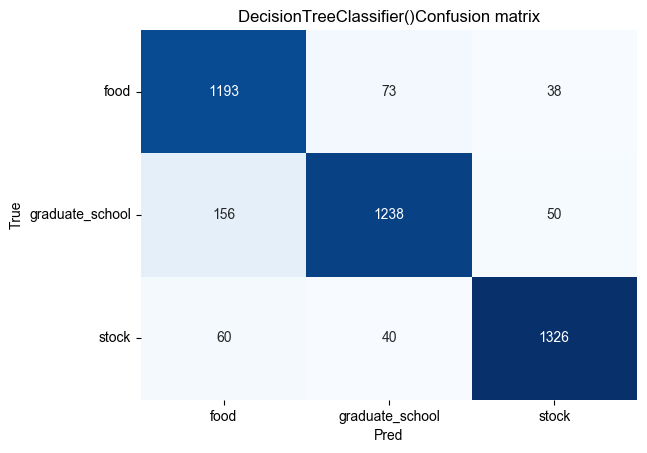

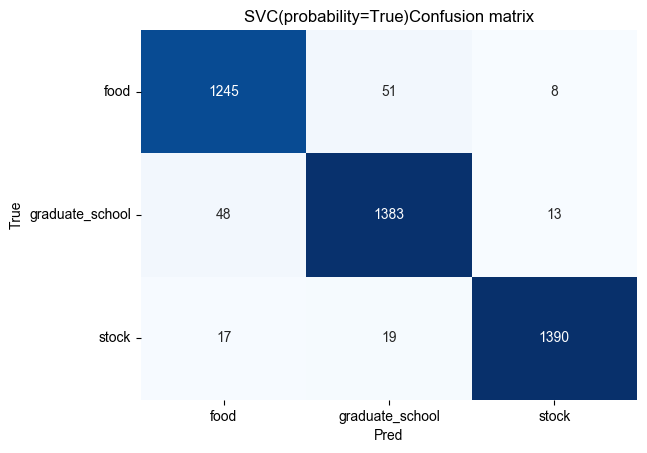

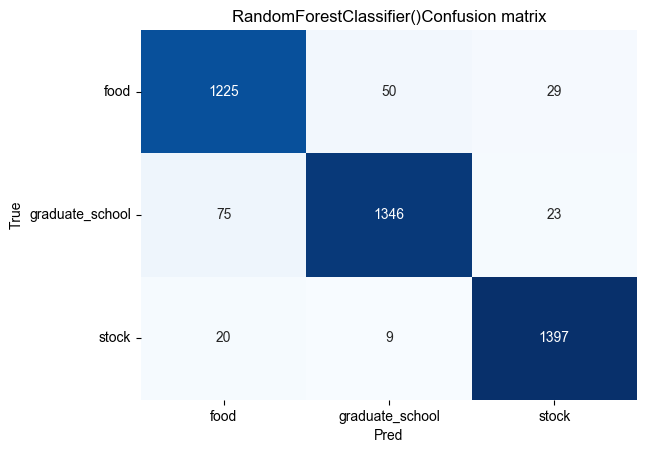

In [51]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


分別觀察各個分類模型在不同類別的評估指標表現如何

In [67]:
result_set['clf_logistic']

{'food': {'precision': 0.9656518345042935,
  'recall': 0.9486196319018405,
  'f1-score': 0.9570599613152805,
  'support': 1304.0},
 'graduate_school': {'precision': 0.9528366370471634,
  'recall': 0.9653739612188366,
  'f1-score': 0.9590643274853801,
  'support': 1444.0},
 'stock': {'precision': 0.9839160839160839,
  'recall': 0.9866760168302945,
  'f1-score': 0.9852941176470589,
  'support': 1426.0},
 'accuracy': 0.9674173454719693,
 'macro avg': {'precision': 0.967468185155847,
  'recall': 0.9668898699836572,
  'f1-score': 0.9671394688159065,
  'support': 4174.0},
 'weighted avg': {'precision': 0.967458177229046,
  'recall': 0.9674173454719693,
  'f1-score': 0.967399254961361,
  'support': 4174.0}}

找出f1-score表現最好的模型是哪個，作為我們最終得到的分類器

In [68]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_logistic
{'accuracy': 0.9674173454719693,
 'food': {'f1-score': 0.9570599613152805,
          'precision': 0.9656518345042935,
          'recall': 0.9486196319018405,
          'support': 1304.0},
 'graduate_school': {'f1-score': 0.9590643274853801,
                     'precision': 0.9528366370471634,
                     'recall': 0.9653739612188366,
                     'support': 1444.0},
 'macro avg': {'f1-score': 0.9671394688159065,
               'precision': 0.967468185155847,
               'recall': 0.9668898699836572,
               'support': 4174.0},
 'stock': {'f1-score': 0.9852941176470589,
           'precision': 0.9839160839160839,
           'recall': 0.9866760168302945,
           'support': 1426.0},
 'weighted avg': {'f1-score': 0.967399254961361,
                  'precision': 0.967458177229046,
                  'recall': 0.9674173454719693,
                  'support': 4174.0}}


從結果可以看到LogisticRegression為我們的best model

In [69]:
y_pred = model_set['clf_logistic'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           food       0.97      0.94      0.96       546
graduate_school       0.94      0.97      0.96       630
          stock       0.99      0.98      0.98       613

       accuracy                           0.97      1789
      macro avg       0.97      0.96      0.97      1789
   weighted avg       0.97      0.97      0.97      1789



輸入資料測試模型的效果

In [70]:
model_set['clf_logistic'].predict(vectorizer.transform(["今年 中山 的 資管所 正取 分數 是 多少"]).toarray())

array(['graduate_school'], dtype=object)

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的迴歸係數

因為LogisticRegression為我們的best model，所以我們用該模型結合cv tokenizer實作下面的範例

In [71]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

從下面的圖表可以了解每個討論版所對應的可解釋字，像出現「好吃」、「美食」、「餐廳」會歸類在美食版，而「請益」、「標的」、「考試」等等則不會歸在美食版

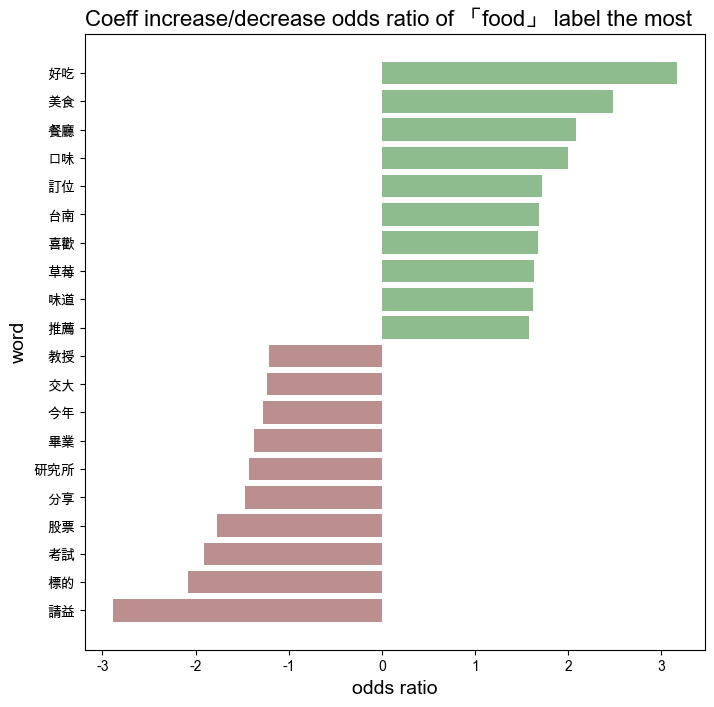

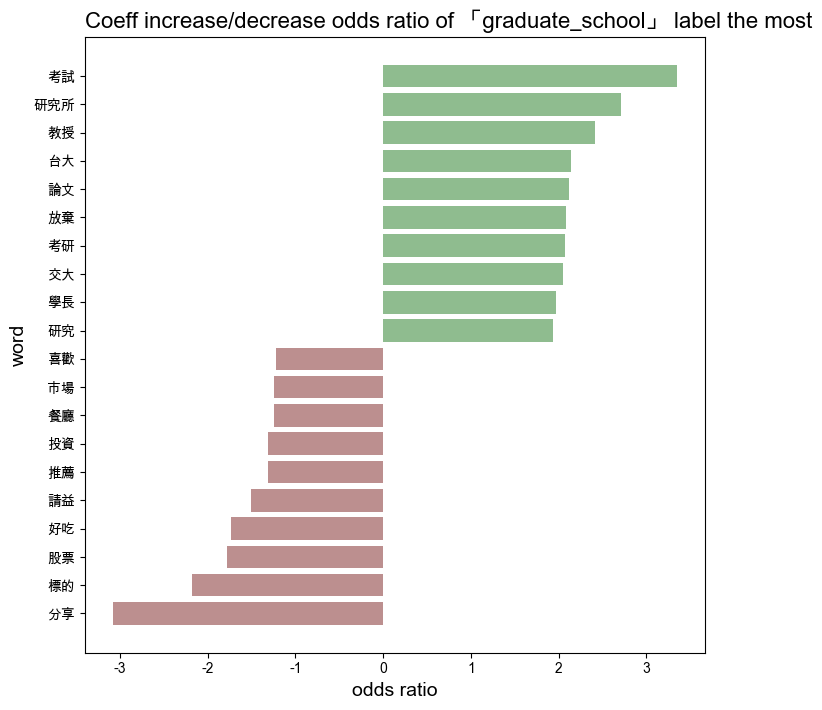

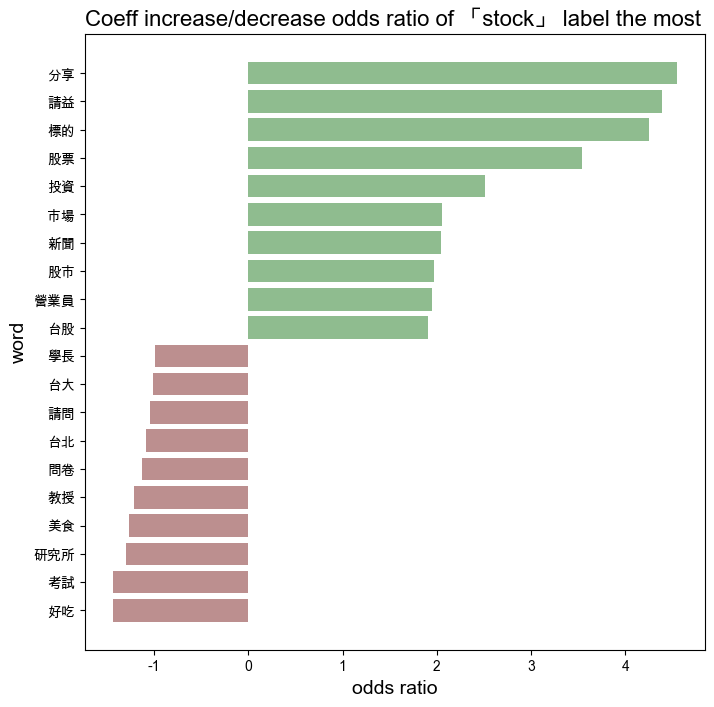

In [72]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

## 6. 用訓練好的分類器來預測其他家的新聞類別

前面我們使用Dcard的資料訓練好了分類器模型，接著用其他家網站的資料測試看看分類的效果。

`sna_ptt_merged.csv` 為PTT＋聯合新聞的資料
- 版別：
  - PTT
    - 研究所
    - 美食
  - 聯合新聞網(2025/03/03-2025/03/10)
    - 股票
- 工作流程平台搜尋/排除關鍵字：無

In [81]:
ct = pd.read_csv("./dataset2/sna_ptt_merged.csv")
ct.dropna(inplace=True)
ct

,system_id,artTitle,artCatagory,artUrl,artContent
0,1,日半導體 迎黃金復甦期,股市,https://udn.com/news/story/10103/8581240,隨著人工智慧（AI）技術迅速發展，全球對高效能運算（HPC）晶片、記憶體與晶圓代工的需求不斷...
1,2,多元布局策略 抗亂流,股市,https://udn.com/news/story/10103/8581243,今年以來，市場輪動快速且震盪起伏。法人指出，全球經濟及企業獲利仍可望溫和成長，全球股市也仍在...
2,3,全球市場觀測站／美股震盪 歐股走揚,股市,https://udn.com/news/story/10103/8581247,美國消費者信心走低，市場擔憂美國經濟前景，美股高檔震盪，全球股市漲跌互見，陸、港股及歐股相對...
3,4,亞股吸睛 對沖基金加碼,股市,https://udn.com/news/story/10103/8581248,近一個月MSCI亞洲指數與MSCI中國指數分別上漲4.6%及17.8%，據高盛最新報告顯示，...
4,5,亞洲非投等債 有戲,股市,https://udn.com/news/story/10103/8581249,近期美國經濟數據偏弱，引發資金避險情緒。法人表示，亞洲非投資等級債擁有相對高的高殖利率，且具...
...,...,...,...,...,...
5065,593,[請益]有關輔大的社會文化與諮商心理學組,graduate,https://www.ptt.cc/bbs/graduate/M.1716647097.A...,我已經有做一些功課，知道輔大心理所社會文化與諮商心理學組的特別之處，\n也有看了幾篇論文，我...
5066,594,113政大科智所上榜心得,graduate,https://www.ptt.cc/bbs/graduate/M.1716732864.A...,一、 背景\n\n學校：國立臺北大學應用外語學系30%\n多益金色證書、無實習經驗\n\n二...
5067,595,研究招募：慢性病照護者,graduate,https://www.ptt.cc/bbs/graduate/M.1716994569.A...,您好，我是國立清華大學就讀服務科學所的研究生\n\n謝謝您點開此篇貼文！我的研究旨在了解慢性...
5068,596,Re:[心得]台大外文所上榜心得,graduate,https://www.ptt.cc/bbs/graduate/M.1717021182.A...,景\n來\n盲\n上\n在\n遊\n度\n慈\n作\n是\n美\n答\n:\n不太懂要怎麼作...


In [82]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,日半導體 迎黃金復甦期隨著人工智慧（AI）技術迅速發展，全球對高效能運算（HPC）晶片、記憶...,https://udn.com/news/story/10103/8581240,股市,半導體 黃金 復甦 人工智慧 AI 技術 迅速 發展 全球 高效能 運算 HPC 晶片 記憶...
1,多元布局策略 抗亂流今年以來，市場輪動快速且震盪起伏。法人指出，全球經濟及企業獲利仍可望溫和...,https://udn.com/news/story/10103/8581243,股市,多元 布局 策略 亂流 今年以來 市場 輪動 快速 震盪 起伏 法人 指出 全球 經濟 企業...
2,全球市場觀測站／美股震盪 歐股走揚美國消費者信心走低，市場擔憂美國經濟前景，美股高檔震盪，全...,https://udn.com/news/story/10103/8581247,股市,全球 市場 觀測站 美股 震盪 歐股 走揚 美國 消費者 信心 走低 市場 擔憂 美國 經濟...
3,亞股吸睛 對沖基金加碼近一個月MSCI亞洲指數與MSCI中國指數分別上漲4.6%及17.8%...,https://udn.com/news/story/10103/8581248,股市,亞股 吸睛 基金 加碼 一個月 MSCI 亞洲 指數 MSCI 中國 指數 分別 上漲 4....
4,亞洲非投等債 有戲近期美國經濟數據偏弱，引發資金避險情緒。法人表示，亞洲非投資等級債擁有相對...,https://udn.com/news/story/10103/8581249,股市,亞洲 投等債 有戲 近期 美國 經濟 數據 偏弱 引發 資金 避險 情緒 法人 表示 亞洲 ...


觀察一下資料集的分佈狀況

In [83]:
ct['artCatagory'].value_counts()

artCatagory
Food        2373
股市          2100
graduate     596
Name: count, dtype: int64

將類別給重新mapping到分類器的類別，接著開始進行分類任務

In [84]:
mapper = {"Food":"food", "graduate":"graduate_school", "股市":"stock"}
ct['artCatagory'] = ct['artCatagory'].map(mapper)

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

                 precision    recall  f1-score   support

           food       1.00      1.00      1.00      2373
graduate_school       0.97      0.99      0.98       596
          stock       1.00      0.99      1.00      2100

       accuracy                           0.99      5069
      macro avg       0.99      0.99      0.99      5069
   weighted avg       0.99      0.99      0.99      5069



從classification report可以發現，分類器的表現很好都接近於1，這有可能是因為各類別差別很大，所以分類器可以很好的區別他們。

In [85]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,半導體 黃金 復甦 人工智慧 AI 技術 迅速 發展 全球 高效能 運算 HPC 晶片 記憶...,stock,stock
1,多元 布局 策略 亂流 今年以來 市場 輪動 快速 震盪 起伏 法人 指出 全球 經濟 企業...,stock,stock
2,全球 市場 觀測站 美股 震盪 歐股 走揚 美國 消費者 信心 走低 市場 擔憂 美國 經濟...,stock,stock
3,亞股 吸睛 基金 加碼 一個月 MSCI 亞洲 指數 MSCI 中國 指數 分別 上漲 4....,stock,stock
4,亞洲 投等債 有戲 近期 美國 經濟 數據 偏弱 引發 資金 避險 情緒 法人 表示 亞洲 ...,stock,stock
...,...,...,...
5065,請益 輔大 社會 文化 諮商 心理學 已經 一些 功課 知道 輔大 心理 社會 文化 諮商 ...,graduate_school,graduate_school
5066,113 政大科智 上榜 心得 背景 學校 國立 臺北 大學 應用 外語 學系 30% 多益 ...,graduate_school,graduate_school
5067,研究 招募 慢性病 照護 您好 國立 清華大學 就讀 服務 科學 研究生 謝謝您 點開 此篇...,graduate_school,graduate_school
5068,Re 心得 台大 外文 上榜 心得 不太懂 作答 題目 19 世紀 身體 視野 文化 建構 ...,graduate_school,graduate_school


將錯誤分類的結果篩選出來

In [86]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
974,高鐵 便當 連漲 利多 預言 下週 股價 網酸 該漲 台灣 高鐵 公司 表示 高鐵 便當 因...,stock,food
1040,承業醫 下午 點重 記者會 說明 董事會 重大 決議 事宜 承業醫 4164 於今 15 0...,stock,food
1055,證交所 發布 IFRS 永續 揭露 準則 S2 氣候 相關 揭露 參考 範例 協助 企業 順...,stock,graduate_school
1085,潤泰 創新 國際 違反 重大 訊息 內部 控制 制度 規定 證交所 違約金 萬元 潤泰 創新...,stock,graduate_school
1099,證券 承銷商 業務 宣導 13 登場 臺灣 證券 交易所 預計 13 舉行 證券 承銷商 業...,stock,graduate_school
1266,翔耀 違反 重訊及 內控 規定 證交所 違約金 20 萬元 翔耀 實業 2438 2024 ...,stock,graduate_school
1290,證交所 舉辦 證券商 導入 金融 信任 架構 作業 問卷 說明會 臺灣 證券 交易所 12 ...,stock,graduate_school
1321,證券商 導入 金融 信任 架構 作業 問卷 證交所 教戰 臺灣 證券 交易所 日前 舉辦 推...,stock,graduate_school
1639,證交所 新代 科技 派司 上市 申請 及熙 特爾 新能源 申請 創新 上市 臺灣 證券 交易...,stock,graduate_school
1646,康和證 資安 缺失 金管會 開罰 30 金管會 康和證 進行 資通 安全 專案 檢查 發現 ...,stock,graduate_school


觀察看看stock類別的新聞，模型給出的分類結果怎麼樣

In [93]:
false_pred.loc[false_pred['artCatagory']=='stock', :]

,words,artCatagory,pred
974,高鐵 便當 連漲 利多 預言 下週 股價 網酸 該漲 台灣 高鐵 公司 表示 高鐵 便當 因...,stock,food
1040,承業醫 下午 點重 記者會 說明 董事會 重大 決議 事宜 承業醫 4164 於今 15 0...,stock,food
1055,證交所 發布 IFRS 永續 揭露 準則 S2 氣候 相關 揭露 參考 範例 協助 企業 順...,stock,graduate_school
1085,潤泰 創新 國際 違反 重大 訊息 內部 控制 制度 規定 證交所 違約金 萬元 潤泰 創新...,stock,graduate_school
1099,證券 承銷商 業務 宣導 13 登場 臺灣 證券 交易所 預計 13 舉行 證券 承銷商 業...,stock,graduate_school
1266,翔耀 違反 重訊及 內控 規定 證交所 違約金 20 萬元 翔耀 實業 2438 2024 ...,stock,graduate_school
1290,證交所 舉辦 證券商 導入 金融 信任 架構 作業 問卷 說明會 臺灣 證券 交易所 12 ...,stock,graduate_school
1321,證券商 導入 金融 信任 架構 作業 問卷 證交所 教戰 臺灣 證券 交易所 日前 舉辦 推...,stock,graduate_school
1639,證交所 新代 科技 派司 上市 申請 及熙 特爾 新能源 申請 創新 上市 臺灣 證券 交易...,stock,graduate_school
1646,康和證 資安 缺失 金管會 開罰 30 金管會 康和證 進行 資通 安全 專案 檢查 發現 ...,stock,graduate_school


挑選一篇stock類別的文章進行觀察，分析為何會將股票預測為美食

In [98]:
pprint(false_pred['words'][974])

('高鐵 便當 連漲 利多 預言 下週 股價 網酸 該漲 台灣 高鐵 公司 表示 高鐵 便當 因應 食材原 物料 成本 持續 增加 今年 調整 售價 120 '
 '高鐵 公司 表示 便當 菜色 仍將 堅持 採用 地化 特色 食材 提供 旅客 搭車 美味 方便 餐食 選擇 網友 不解 表示 該漲 應該 票價 便當 '
 '一票人 直呼 台鐵 便當 完勝 高鐵 便當 2015 日起 2024 31 長達 售價 維持 100 然因 食材 物料 成本 持續 增加 去年 首次 '
 '調漲 110 今年 調整 售價 120 TGo 會員 95 便當 優惠 至今 月底 截止 一名 網友 PTT 轉題 新聞 表示 高鐵 便當 已經 去年初 '
 '上漲 20% 過去 凍漲 連續 兩年 調漲 下週 高鐵 應該 利多 股價 準備 噴噴 其他人 留言 板橋 台北 南港 這三站 旅客 改買台 便當 高鐵 '
 '高鐵 便當 台鐵 便當 我會 地方 CP 真的 不高 還好 便當 認為 該漲 車票 留言 最好 票價 20% 便當 衝三小 自由 座給 先漲 20% '
 '票價 應該 票價 便當 來補 電費 開漲 票價 不敢 票價 票價')


In [104]:
ct["content"][974]

'高鐵便當連漲2年是利多？他預言下週股價跟漲 網酸：該漲的是它台灣高鐵公司表示，「高鐵便當」因應食材原物料等成本持續增加，自今年4月起調整售價為120元。高鐵公司表示，便當菜色仍將堅持採用在地化特色食材，提供旅客搭車時更美味、方便的餐食選擇。網友不解表示，該漲的應該是票價，而不是便當，也有一票人直呼「台鐵便當完勝！」「高鐵便當」從2015年4月1日起至2024年3月31日，長達9年售價維持在100元，然因食材、原物料等成本持續增加，去年4月1日首次調漲至110元，今年4月起再調整售價為120元。此外， TGo會員95折便當優惠至今年3月底截止。一名網友在PTT轉題新聞並表示，高鐵便當已經比去年初上漲20%，過去是凍漲9年，如今卻連續兩年調漲，他笑稱「這樣下週對高鐵應該是利多吧？股價是不是準備噴噴了！」其他人留言「板橋，台北，南港這三站的旅客可以改買台鐵便當再進去搭高鐵」、「坐高鐵吃台鐵便當」、「台鐵便當屌打」、「我會寧願去其他地方買的說，這CP值真的不高」、「還好我都買台鐵便當」。不少人認為該漲的是車票，留言「最好票價也漲20%」、「漲便當衝三小？自由座給我先漲20%」、「票價也應該漲」、「票價不漲，便當來補」、「電費漲，開漲票價了吧」、「怎不敢漲票價」、「不懂為啥票價不漲」。'

## 主題模型
主題模型（Topic Modeling）是一種無監督學習技術，用於從大量文本中自動識別潛在的主題。本次使用LDA模型進行主題分析，並結合視覺化工具與情緒分析，探索文本資料中的主題分佈與情緒趨勢。

In [ ]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint
from wordcloud import WordCloud 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
dcard = pd.read_csv("./dcard_merged.csv")  # 匯資料
dcard = dcard.rename(columns={'boardID': 'artCatagory'})
dcard.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,artCatagory,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/stock/p/257746054,2025-01-13 12:00:00,#分享 台積電法說前5大重點：成長動能與先進製程布局,\n台積電作為全球半導體製造領域的領導者，其每季法說會都吸引投資人、分析師及產業人士高度關注...,stock,1,ian_money,M,Ian編的理財筆記💸
1,2,Dcard,https://www.dcard.tw/f/stock/p/257763144,2025-01-15 13:55:51,#分享 1/15 晚上21:30 美國CPI公布2.9 ％🎉台指期噴發至+360點,\n1/15 晚上21:30 美國CPI公布2.9 ％\n附合預期\n台指期噴發至+360點...,stock,1,sckaofutures,M,期貨俠高玩
2,3,Dcard,https://www.dcard.tw/f/stock/p/257763102,2025-01-15 13:50:21,#標的 亞光3019，12月 合併營收21.45億元，創近3個月以來新高營收表現亮眼；數據利...,NaN,stock,1,jing7515,F,靜


In [ ]:
dcard = dcard.dropna(subset=['artTitle'])
dcard = dcard.dropna(subset=['artContent'])
# 移除網址格式
# 只留下中文字
dcard["artContent"] = dcard["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard["artTitle"] = dcard["artTitle"].str.replace("(http|https)://.*", "", regex=True)
dcard["artContent"] = dcard["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard["artTitle"] = dcard["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard['artDate'] = pd.to_datetime(dcard['artDate'])
dcard['content'] = dcard['artTitle'] + dcard['artContent']


dcard = dcard.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
dcard.head(3)

,content,artUrl,artCatagory,artDate
0,分享台積電法說前大重點成長動能與先進製程布局台積電作為全球半導體製造領域的領導者其每季法說會...,https://www.dcard.tw/f/stock/p/257746054,stock,2025-01-13 12:00:00
1,分享晚上美國公布台指期噴發至點晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,https://www.dcard.tw/f/stock/p/257763144,stock,2025-01-15 13:55:51
3,標的明日的再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責...,https://www.dcard.tw/f/stock/p/257763489,stock,2025-01-15 14:33:09


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

dcard["words"] = dcard["content"].apply(getToken)
dcard.head()

Building prefix dict from c:\Users\user\1132_社群媒體分析_MIS581\讀書會專案\專案二\第二組_第二次讀書會\dict\dict.txt.big ...
2025-04-20 17:51:44,623 : DEBUG : Building prefix dict from c:\Users\user\1132_社群媒體分析_MIS581\讀書會專案\專案二\第二組_第二次讀書會\dict\dict.txt.big ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.ucd8e97a985a7f96ce08993ff7408e4e9.cache
2025-04-20 17:51:46,649 : DEBUG : Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.ucd8e97a985a7f96ce08993ff7408e4e9.cache
Loading model cost 2.164 seconds.
2025-04-20 17:51:46,790 : DEBUG : Loading model cost 2.164 seconds.
Prefix dict has been built successfully.
2025-04-20 17:51:46,792 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,分享台積電法說前大重點成長動能與先進製程布局台積電作為全球半導體製造領域的領導者其每季法說會...,https://www.dcard.tw/f/stock/p/257746054,stock,2025-01-13 12:00:00,"[分享, 台積, 電法, 重點, 成長, 動能, 先進, 製程, 布局, 台積, 電作, 全..."
1,分享晚上美國公布台指期噴發至點晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,https://www.dcard.tw/f/stock/p/257763144,stock,2025-01-15 13:55:51,"[分享, 晚上, 美國, 公布, 指期, 噴發, 至點, 晚上, 美國, 公布, 附合, 預..."
3,標的明日的再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責...,https://www.dcard.tw/f/stock/p/257763489,stock,2025-01-15 14:33:09,"[標的, 明日, 再加, 一張, 一日, 行情, 券多, 一張, 多一分, 快樂, 做空, ..."
4,分享股癌看我獨自升級官感股市近況挖礦機相關故事股癌筆記分享贊助贊助看我獨自升級官感我獨自升級...,https://www.dcard.tw/f/stock/p/257763520,stock,2025-01-15 14:36:11,"[分享, 股癌, 升級, 官感, 股市, 近況, 挖礦, 相關, 故事, 股癌, 筆記, 分..."
5,分享對上櫃指數及中小型個股的看法大家好我是威力今天想要來分享我對上櫃指數的看法因為我主要是交...,https://www.dcard.tw/f/stock/p/257747161,stock,2025-01-13 14:00:13,"[分享, 上櫃, 指數, 中小型, 個股, 看法, 威力, 今天, 要來, 分享, 上櫃, ..."


將斷詞後的doc['words']轉換成list

In [ ]:
docs = dcard['words'].to_list()
docs[0]

['分享',
 '台積',
 '電法',
 '重點',
 '成長',
 '動能',
 '先進',
 '製程',
 '布局',
 '台積',
 '電作',
 '全球',
 '半導體',
 '製造',
 '領域',
 '領導者',
 '每季',
 '法說',
 '吸引',
 '投資人',
 '分析師',
 '產業',
 '人士',
 '高度',
 '關注',
 '本次',
 '法說',
 '將成',
 '了解',
 '公司',
 '未來',
 '成長',
 '動能',
 '先進',
 '製程',
 '布局',
 '全球',
 '半導體',
 '產業',
 '走向',
 '重要',
 '契機',
 '以下',
 '將從',
 '市場',
 '預期',
 '財務數據',
 '產業',
 '趨勢',
 '未來',
 '挑戰',
 '幾個',
 '層面',
 '進行',
 '分析',
 '前瞻',
 '市場',
 '預期',
 '回升',
 '關鍵',
 '訊號',
 '全球',
 '經濟',
 '逐漸',
 '從通',
 '壓力',
 '供應鏈',
 '瓶頸',
 '復甦',
 '市場',
 '普遍',
 '期待',
 '台積',
 '電在',
 '成長',
 '動能',
 '重新',
 '啟動',
 '本次',
 '法說',
 '重點',
 '在於',
 '確認',
 '台積電',
 '透過',
 '技術',
 '領先',
 '優勢',
 '客戶',
 '需求',
 '洞察',
 '抓住',
 '人工智慧',
 '高效能',
 '運算',
 '車用',
 '電子',
 '及物',
 '聯網',
 '新興',
 '應用',
 '成長',
 '機會',
 '特別',
 '晶片',
 '需求',
 '帶動',
 '產能',
 '擴張',
 '是否',
 '未來',
 '數年',
 '持續',
 '貢獻',
 '業績',
 '將成',
 '市場',
 '焦點',
 '財務',
 '表現',
 '毛利率',
 '資本',
 '支出',
 '計劃',
 '關注',
 '台積電',
 '毛利率',
 '向來',
 '評估',
 '競爭力',
 '重要',
 '指標',
 '隨著奈米',
 '量產',
 '奈米',
 '製程',
 '逐漸',
 '成為',
 '營收',
 '主力',
 '

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

    no_below=5 出現在少於 5 篇文章中的詞會被移除
    
    no_above=0.99 出現在超過 99% 文件中的詞會被移除

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2025-04-20 17:52:12,380 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-20 17:52:13,027 : INFO : built Dictionary<48817 unique tokens: ['一舉一動', '三星', '上下游', '上將', '不容忽視']...> from 5963 documents (total 413887 corpus positions)
2025-04-20 17:52:13,028 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<48817 unique tokens: ['一舉一動', '三星', '上下游', '上將', '不容忽視']...> from 5963 documents (total 413887 corpus positions)", 'datetime': '2025-04-20T17:52:13.028688', 'gensim': '4.3.3', 'python': '3.11.0 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-04-20 17:52:13,073 : INFO : discarding 39868 tokens: [('一舉一動', 2), ('上下游', 1), ('不容忽視', 1), ('並存', 1), ('亞太地區', 2), ('分散化', 1), ('及物', 3), ('契機', 4), ('居於', 1), ('從通', 1)]...
2025-04-20 17:52:13,074 : INFO : keeping 8949 tokens which were in no less than 5 and no more than 5903 (=99.0%) documents
2025-04-20 17:5

Dictionary<8949 unique tokens: ['三星', '上將', '並對', '主力', '主要']...>


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。
<br>每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

三星: 0
上將: 1
並對: 2
主力: 3
主要: 4
了解: 5
亞利桑那州: 6
人士: 7
人工智慧: 8
今年: 9
代工廠: 10
以下: 11


In [ ]:
pprint(" ".join(dcard['words'].iloc[600]))

('新聞 晨間 新聞 晨間 新聞 新聞 摘要 仁勳 號稱 目前 最快 顯卡 系列 宣布 推出 平台 技術 應用 自駕車 機器人 發展 主計 總處 今日 公布 '
 '消費者 物價指數 年增率 緩漲 平均 增則 來到 主計 總處估 今年 走過 元年 宏碁 微星 展前 系列 新品 競出 搭載 輝達 超微 英特爾 最新 '
 '晶片 筆電桌 機到 掌機 體驗 全面 升級 蘋果 推出 最新 研發 機器人 運算 效率 超越 輝達 研調 電視 面板 需求 維持 熱絡 部分 尺寸 上漲 '
 '美元 仁勳 高喊 實體 時代 到來 欽點 廣運 和碩 所羅門 家台 優惠 原價 由此 連結 加入 即可 享有 折扣 折扣 加贈 下載 連結 此為 過往 '
 '相對 優惠價 點進 參考 操作 順利 分享 幫助 別忘了 留言 觀看 股市 基礎知識 追蹤')


In [ ]:
dictionary.doc2bow(dcard['words'].iloc[600])[:10]

[(9, 1),
 (24, 1),
 (25, 1),
 (32, 1),
 (53, 1),
 (75, 1),
 (79, 1),
 (99, 1),
 (102, 1),
 (148, 1)]

將docs轉換成BOW形式<br>
把每篇文件的 token list 轉換成一組 (token_id, count) 的 list

In [ ]:
# 建立 Bag-of-words 作為文章的特徵表示
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2024, # 亂數
)

2025-04-20 17:52:13,629 : INFO : using symmetric alpha at 0.1
2025-04-20 17:52:13,631 : INFO : using symmetric eta at 0.1
2025-04-20 17:52:13,633 : INFO : using serial LDA version on this node
2025-04-20 17:52:13,646 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5963 documents, updating model once every 2000 documents, evaluating perplexity every 5963 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 17:52:13,648 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2025-04-20 17:52:13,649 : INFO : PROGRESS: pass 0, at document #2000/5963
2025-04-20 17:52:14,999 : INFO : merging changes from 2000 documents into a model of 5963 documents
2025-04-20 17:52:15,009 : INFO : topic #0 (0.100): 0.009*"投資" + 0.008*"分享" + 0.008*"市場" + 0.007*"技術" + 0.006*"美國" + 0.006*"股價" + 0.006*"買賣" + 0.005*"標的" + 0.004*"目前" + 0.004*"外資"
2025-04-20 17:52

In [ ]:
ldamodel.print_topics()

2025-04-20 17:52:18,539 : INFO : topic #0 (0.100): 0.020*"面試" + 0.012*"問卷" + 0.012*"聯名" + 0.012*"花生" + 0.009*"抽獎" + 0.008*"科大" + 0.008*"活動" + 0.005*"研究" + 0.005*"進行" + 0.005*"分享"
2025-04-20 17:52:18,541 : INFO : topic #1 (0.100): 0.019*"牛排" + 0.015*"美食" + 0.008*"轉讓" + 0.007*"放棄" + 0.007*"老師" + 0.006*"分享" + 0.006*"已經" + 0.005*"市場" + 0.005*"學校" + 0.005*"貼心"
2025-04-20 17:52:18,543 : INFO : topic #2 (0.100): 0.025*"好吃" + 0.014*"口味" + 0.013*"覺得" + 0.012*"蛋糕" + 0.012*"味道" + 0.012*"真的" + 0.011*"喜歡" + 0.011*"草莓" + 0.009*"比較" + 0.009*"分享"
2025-04-20 17:52:18,544 : INFO : topic #3 (0.100): 0.017*"老師" + 0.015*"教授" + 0.009*"台中市" + 0.008*"台股" + 0.008*"二段" + 0.008*"分享" + 0.007*"對比" + 0.007*"封關" + 0.005*"禮券" + 0.004*"市場"
2025-04-20 17:52:18,545 : INFO : topic #4 (0.100): 0.035*"最新" + 0.014*"買一送一" + 0.014*"桃園" + 0.012*"內容" + 0.010*"更新" + 0.010*"中壢" + 0.010*"滿滿" + 0.009*"資工" + 0.009*"優惠" + 0.009*"版本"
2025-04-20 17:52:18,547 : INFO : topic #5 (0.100): 0.013*"美食" + 0.009*"分鐘" + 0.008*"小時候" + 0.008*"朋友" 

[(0,
  '0.020*"面試" + 0.012*"問卷" + 0.012*"聯名" + 0.012*"花生" + 0.009*"抽獎" + 0.008*"科大" + 0.008*"活動" + 0.005*"研究" + 0.005*"進行" + 0.005*"分享"'),
 (1,
  '0.019*"牛排" + 0.015*"美食" + 0.008*"轉讓" + 0.007*"放棄" + 0.007*"老師" + 0.006*"分享" + 0.006*"已經" + 0.005*"市場" + 0.005*"學校" + 0.005*"貼心"'),
 (2,
  '0.025*"好吃" + 0.014*"口味" + 0.013*"覺得" + 0.012*"蛋糕" + 0.012*"味道" + 0.012*"真的" + 0.011*"喜歡" + 0.011*"草莓" + 0.009*"比較" + 0.009*"分享"'),
 (3,
  '0.017*"老師" + 0.015*"教授" + 0.009*"台中市" + 0.008*"台股" + 0.008*"二段" + 0.008*"分享" + 0.007*"對比" + 0.007*"封關" + 0.005*"禮券" + 0.004*"市場"'),
 (4,
  '0.035*"最新" + 0.014*"買一送一" + 0.014*"桃園" + 0.012*"內容" + 0.010*"更新" + 0.010*"中壢" + 0.010*"滿滿" + 0.009*"資工" + 0.009*"優惠" + 0.009*"版本"'),
 (5,
  '0.013*"美食" + 0.009*"分鐘" + 0.008*"小時候" + 0.008*"朋友" + 0.007*"畢業" + 0.007*"哀居" + 0.006*"分享" + 0.006*"今年" + 0.006*"帶有" + 0.006*"喜歡"'),
 (6,
  '0.012*"美食" + 0.011*"真的" + 0.010*"推薦" + 0.009*"研究所" + 0.008*"目前" + 0.008*"學長" + 0.008*"喜歡" + 0.007*"放棄" + 0.007*"請問" + 0.007*"知道"'),
 (7,
  '0.011*"地址" + 0

In [ ]:
ldamodel.get_document_topics(corpus[0])

[(0, 0.32692033), (1, 0.17690429), (3, 0.49419823)]

### 查看 LDA 模型指標

In [ ]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2025-04-20 17:52:22,625 : INFO : -9.130 per-word bound, 560.2 perplexity estimate based on a held-out corpus of 5963 documents with 346121 words


-9.129771187808336

In [ ]:
np.exp2(-perplexity)

560.1895216470575

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

2025-04-20 17:52:22,673 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2025-04-20 17:52:55,429 : INFO : 1 batches submitted to accumulate stats from 64 documents (5297 virtual)
2025-04-20 17:52:55,432 : INFO : 2 batches submitted to accumulate stats from 128 documents (8815 virtual)
2025-04-20 17:52:55,435 : INFO : 3 batches submitted to accumulate stats from 192 documents (12072 virtual)
2025-04-20 17:52:55,438 : INFO : 4 batches submitted to accumulate stats from 256 documents (15662 virtual)
2025-04-20 17:52:55,441 : INFO : 5 batches submitted to accumulate stats from 320 documents (20037 virtual)
2025-04-20 17:52:55,446 : INFO : 6 batches submitted to accumulate stats from 384 documents (23639 virtual)
2025-04-20 17:52:55,452 : INFO : 7 batches submitted to accumulate stats from 448 documents (28216 virtual)
2025-04-20 17:52:55,456 : INFO : 8 batches submitted to accumulate stats from 512 documents (33107

這個主題模型的 PMI score:  -0.10129119586717487


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[-0.08712904260751012,
 -0.21220646093527776,
 0.0038690881519432103,
 -0.17878548452798343,
 -0.17178860754719413,
 -0.10389117115855823,
 0.027925053073445706,
 -0.09381367373126011,
 -0.10815850425261055,
 -0.08893315513674338]

### 透過指標找出最佳主題數

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2025-04-20 17:52:57,211 : INFO : using symmetric alpha at 0.5
2025-04-20 17:52:57,212 : INFO : using symmetric eta at 0.5
2025-04-20 17:52:57,215 : INFO : using serial LDA version on this node
2025-04-20 17:52:57,219 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5963 documents, updating model once every 2000 documents, evaluating perplexity every 5963 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 17:52:57,220 : INFO : PROGRESS: pass 0, at document #2000/5963
2025-04-20 17:52:58,867 : INFO : merging changes from 2000 documents into a model of 5963 documents
2025-04-20 17:52:58,870 : INFO : topic #0 (0.500): 0.010*"台股" + 0.009*"分享" + 0.008*"標的" + 0.008*"封關" + 0.007*"股票" + 0.007*"請益" + 0.007*"對比" + 0.006*"市場" + 0.005*"買賣" + 0.005*"目前"
2025-04-20 17:52:58,873 : INFO : topic #1 (0.500): 0.013*"分享" + 0.012*"市場" + 0.011*"投資" + 0.006*"股票" + 0.005*"美國" + 0.005*"股價" + 0.005*"目前" + 0.004*"美股" + 0.004*"預期" + 0.004*"

花費時間: 339.96478152275085 sec


In [ ]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2983.407679,0.034997
1,3,2880.001425,0.025155
2,4,2470.476761,0.020283
3,5,2378.292898,-0.016623
4,6,2438.736776,0.020852
5,7,2296.115378,-0.001825


c:\Users\user\anaconda3\envs\sma\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\user\anaconda3\envs\sma\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\user\anaconda3\envs\sma\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='topic_num'>

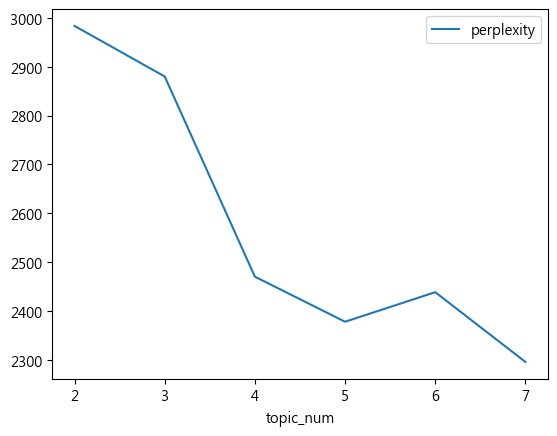

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

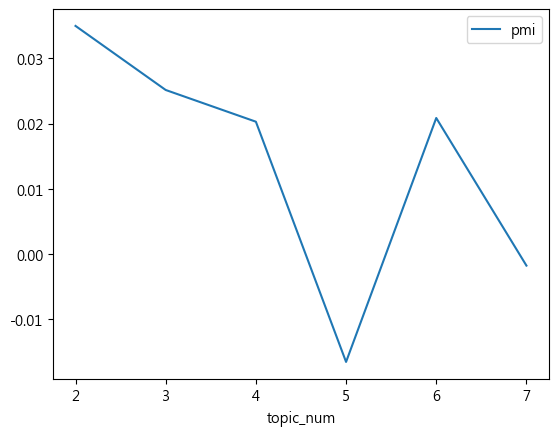

In [ ]:
result.plot.line(x='topic_num', y='pmi')

綜合考量模型的解釋力與主題的語意一致性，雖然在 Perplexity 指標中 7 題的數值最低，代表對語料擬合最佳，但在 PMI 指標中，6 題表現相對較佳，顯示其主題內部詞彙的語意較集中、一致性較好。為兼顧模型效果與主題可解釋性，最終決定採用 6 個主題 作為 LDA 模型的主題數設定。

### 視覺化呈現

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 6,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2025-04-20 17:58:37,687 : INFO : using symmetric alpha at 0.16666666666666666
2025-04-20 17:58:37,688 : INFO : using symmetric eta at 0.16666666666666666
2025-04-20 17:58:37,691 : INFO : using serial LDA version on this node
2025-04-20 17:58:37,698 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 5963 documents, updating model once every 2000 documents, evaluating perplexity every 5963 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-20 17:58:37,700 : INFO : PROGRESS: pass 0, at document #2000/5963
2025-04-20 17:58:39,083 : INFO : merging changes from 2000 documents into a model of 5963 documents
2025-04-20 17:58:39,088 : INFO : topic #2 (0.167): 0.015*"分享" + 0.008*"投資" + 0.007*"目前" + 0.007*"市場" + 0.007*"股票" + 0.007*"建議" + 0.006*"請益" + 0.005*"標的" + 0.005*"買賣" + 0.005*"營收"
2025-04-20 17:58:39,090 : INFO : topic #0 (0.167): 0.010*"台股" + 0.008*"對比" + 0.008*"分享" + 0.008*"買賣" + 0.008*"封關" + 0.008*"標的" + 0.007*"市場" + 0

In [ ]:
import gensim
gensim.__version__

'4.3.3'

In [ ]:
from pyLDAvis import gensim_models

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.155782  0.192930       1        1  25.948376
4      0.114967 -0.120166       2        1  22.046283
5     -0.227229 -0.051751       3        1  21.146873
0      0.286281 -0.021546       4        1  12.335217
2     -0.112607 -0.184700       5        1   9.739583
1      0.094370  0.185234       6        1   8.783668, topic_info=     Term         Freq        Total Category  logprob  loglift
5845   放棄   691.000000   691.000000  Default  30.0000  30.0000
1244   教授   951.000000   951.000000  Default  29.0000  29.0000
931    研究  1051.000000  1051.000000  Default  28.0000  28.0000
4538   好吃  1443.000000  1443.000000  Default  27.0000  27.0000
358    真的  1656.000000  1656.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
976    搭配    99.745032   605.291477   Topic6  -5.7197   0.6292
272    台灣    90.102008   474.031470   Topic6  -5.8213   0.7719
392    認為    76.448047   228.840904   Topic6  -5.9857   1.3359
70     影響    84.210400   440.280866   Topic6  -5.8889   0.7782
4716   味道    80.909087   786.834725   Topic6  -5.9289   0.1576

[451 rows x 6 columns], token_table=      Topic      Freq Term
term                      
224       1  0.206972   一下
224       2  0.259487   一下
224       3  0.220358   一下
224       4  0.022654   一下
224       5  0.285230   一下
...     ...       ...  ...
6041      5  0.007397   鮭魚
6041      6  0.495583   鮭魚
2692      6  0.978141  麥當勞
5824      5  0.995125   點心
2558      1  0.990898   點收

[1160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 1, 3, 2])

目前看起來分類結果在主題數為6還不錯，主題之間沒有重疊，大小還算平均。

In [ ]:
pyLDAvis.save_html(p, "lda_zh.html")

## GuidedLDA

In [ ]:
import guidedlda

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
    ["投資", "股票", "台股", "美股", "分析"],  #股市與投資討論
    ["蛋糕", "巧克力", "口味", "料理", "火鍋"],#飲食經驗分享（料理篇）
    ["研究", "教授", "考試", "研究所", "面試"],#升學與學術壓力
    ["放棄", "希望", "覺得", "有沒有", "謝謝"],#情緒分享
    ["好吃", "推薦", "美食", "餐廳", "口味"],  #美食推薦與評價
    ["口感", "味道", "草莓", "蛋糕", "巧克力"] #甜點風味與感官描述
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-20 17:59:04,381 : INFO : n_documents: 5963
2025-04-20 17:59:04,383 : INFO : vocab_size: 8949
2025-04-20 17:59:04,384 : INFO : n_words: 346121
2025-04-20 17:59:04,386 : INFO : n_topics: 6
2025-04-20 17:59:04,390 : INFO : n_iter: 100


2025-04-20 17:59:04,476 : WARNING : all zero row in document-term matrix found
2025-04-20 17:59:06,514 : INFO : <0> log likelihood: -3702203
2025-04-20 17:59:07,267 : INFO : <20> log likelihood: -2765143
2025-04-20 17:59:07,943 : INFO : <40> log likelihood: -2746552
2025-04-20 17:59:08,571 : INFO : <60> log likelihood: -2739115
2025-04-20 17:59:09,194 : INFO : <80> log likelihood: -2735823
2025-04-20 17:59:09,800 : INFO : <99> log likelihood: -2732362


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_
# 取得corpus全部的詞彙表
vocab = tuple(dictionary.token2id.keys())

for i, topic_dist in enumerate(topic_word):
    # 依照詞語機率從小到大排序，找出每個主題的前十個關鍵詞
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_ # 文件-主題 分佈
term_freq = tuple(dictionary.cfs.values()) # 每個詞在整個語料中出現的總次數
doc_len = [sum(v for k, v in doc) for doc in corpus] # 每篇文章的長度

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 投資 分享 股票 台股 標的 請益 美股 交易 目前 封關
Topic 1: 市場 美國 股價 公司 營收 技術 預期 影響 成長 表現
Topic 2: 研究 教授 問卷 面試 研究所 老師 時間 問題 相關 目前
Topic 3: 放棄 知道 請問 真的 希望 一下 覺得 已經 有人 有沒有
Topic 4: 推薦 美食 好吃 優惠 餐廳 真的 台北 喜歡 料理 朋友
Topic 5: 口感 覺得 口味 好吃 蛋糕 草莓 喜歡 味道 真的 搭配


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.067251 -0.190714       1        1  18.024193
5     -0.195937  0.163902       2        1  17.372725
4     -0.217761  0.100195       3        1  17.323419
0      0.112477 -0.050119       4        1  16.252138
1      0.313118  0.179865       5        1  15.745008
3     -0.079147 -0.203129       6        1  15.282518, topic_info=     Term         Freq        Total Category  logprob  loglift
313    投資  1082.000000  1082.000000  Default  30.0000  30.0000
63     市場  1237.000000  1237.000000  Default  29.0000  29.0000
379    股票   837.000000   837.000000  Default  28.0000  28.0000
931    研究  1045.000000  1045.000000  Default  27.0000  27.0000
5845   放棄   791.000000   791.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
541    請益   271.371345   853.361657   Topic6  -5.2726   0.7328
274    問題   253.413607   836.597081   Topic6  -5.3411   0.6841
1376   最後   229.469957   644.961991   Topic6  -5.4403   0.8450
322    時間   227.474653   987.372404   Topic6  -5.4490   0.4105
336    比較   221.488740  1366.921636   Topic6  -5.4757   0.0585

[405 rows x 6 columns], token_table=      Topic      Freq Term
term                      
224       1  0.142677   一下
224       2  0.077542   一下
224       3  0.179897   一下
224       4  0.128203   一下
224       6  0.472489   一下
...     ...       ...  ...
1902      1  0.180431   麻煩
1902      3  0.023741   麻煩
1902      4  0.028489   麻煩
1902      6  0.769206   麻煩
2558      4  1.001469   點收

[750 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 1, 2, 4])

- 主題 2 和主題有重疊，表示它們的字詞分布與語意相近。
- 主題 5 位於右上角，與其他主題距離較遠，可能具有獨特的語意。
- 主題 4 和主題 6 較為集中，顯示內容也較一致。

下面透過增加每一個組的詞語，希望讓模型根據這些詞彙學習特定語意方向的主題。

In [ ]:
seed_topic_list = [
    # 股市與投資討論
    ["投資", "股票", "台股", "美股", "分析", "報酬", "財報", "市場", "基金", "利率", "股市", "股價", "經濟", "操盤"],

    # 飲食經驗分享（料理篇）
    ["火鍋", "料理", "麻辣", "炸物", "日式", "韓式", "中餐", "晚餐", "便當", "燒烤", "套餐", "點餐", "食材"],

    # 升學與學術壓力
    ["研究", "教授", "考試", "研究所", "面試", "筆試", "報考", "成績", "推甄", "論文", "實驗室", "科系", "口試", "準備", "學歷"],

    # 情緒分享
    ["放棄", "希望", "覺得", "謝謝", "壓力", "崩潰", "心情", "求救", "有人", "煩惱", "憂鬱", "焦慮", "很累", "痛苦"],

    # 美食推薦與評價
    ["好吃", "推薦", "美食", "餐廳", "名店", "排隊", "小吃",  "用餐", "服務", "訂位", "評價", "食記"],

    # 甜點風味與感官描述
    ["蛋糕", "巧克力", "口感", "味道", "草莓", "甜點", "奶油", "脆皮", "綿密", "苦甜", "布丁", "慕斯", "甜食"]
]


seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2025-04-20 17:59:12,315 : INFO : n_documents: 5963
2025-04-20 17:59:12,320 : INFO : vocab_size: 8949
2025-04-20 17:59:12,321 : INFO : n_words: 346121
2025-04-20 17:59:12,322 : INFO : n_topics: 6
2025-04-20 17:59:12,323 : INFO : n_iter: 100


2025-04-20 17:59:12,369 : WARNING : all zero row in document-term matrix found
2025-04-20 17:59:14,377 : INFO : <0> log likelihood: -3684895
2025-04-20 17:59:15,067 : INFO : <20> log likelihood: -2764888
2025-04-20 17:59:15,723 : INFO : <40> log likelihood: -2745600
2025-04-20 17:59:16,399 : INFO : <60> log likelihood: -2739884
2025-04-20 17:59:17,102 : INFO : <80> log likelihood: -2735694
2025-04-20 17:59:17,789 : INFO : <99> log likelihood: -2733348


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 市場 分享 投資 台股 標的 美國 股價 公司 技術 營收
Topic 1: 優惠 最新 多吉 內容 活動 文章 懶人 資訊 分享 全家
Topic 2: 研究 教授 問卷 研究所 面試 老師 考試 問題 時間 準備
Topic 3: 放棄 請益 目前 知道 請問 真的 現在 希望 有人 已經
Topic 4: 好吃 推薦 美食 真的 喜歡 餐廳 覺得 台北 朋友 料理
Topic 5: 口感 口味 蛋糕 草莓 覺得 味道 喜歡 搭配 甜點 巧克力


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.225385  0.152791       1        1  24.550114
2      0.006208  0.175618       2        1  20.485591
4     -0.225812 -0.044277       3        1  17.746677
3     -0.081444  0.155182       4        1  15.996098
5     -0.167536 -0.180053       5        1  15.774916
1      0.243200 -0.259261       6        1   5.446605, topic_info=     Term         Freq        Total Category  logprob  loglift
4538   好吃  1371.000000  1371.000000  Default  30.0000  30.0000
2132   優惠   542.000000   542.000000  Default  29.0000  29.0000
7372   口感   810.000000   810.000000  Default  28.0000  28.0000
5845   放棄   791.000000   791.000000  Default  27.0000  27.0000
63     市場  1237.000000  1237.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
12     使用   143.624145   408.254842   Topic6  -4.8772   1.8655
502    連結   114.701847   289.469339   Topic6  -5.1020   1.9845
25     分享   182.519650  2465.492622   Topic6  -4.6375   0.3069
215    推薦   145.618786  1323.915054   Topic6  -4.8634   0.7028
590    留言    92.760792   324.370328   Topic6  -5.3143   1.6583

[412 rows x 6 columns], token_table=      Topic      Freq Term
term                      
224       1  0.037216   一下
224       2  0.248109   一下
224       3  0.198487   一下
224       4  0.446595   一下
224       5  0.070297   一下
...     ...       ...  ...
1902      4  0.712160   麻煩
8084      5  1.000665   黑糖
4296      3  1.000733   點了
2558      1  1.000759   點收
3065      6  0.999352   點進

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 6, 2])

從 PyLDAVis 的視覺化結果來看，各主題間大致有明顯區隔，且高頻詞與種子詞匹配良好，顯示模型已能穩定辨識語料中的潛在主題結構

## 主題分佈的應用，搭配其他文章資訊 (LDA)

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(3, 0.7992837), (4, 0.17755936)]

#### 將 LDA 模型推論後的每篇文件的 主題分布（也就是 𝜃）轉換成一個 NumPy 矩陣（array）

In [ ]:
# 把 gensim 的稀疏表示法轉成稀疏矩陣
m_theta = corpus2csc(topics_doc).T.toarray() # 倒置讓shape變為(num_docs, num_topics)
m_theta

array([[0.        , 0.10976587, 0.        , 0.888349  , 0.        ,
        0.        ],
       [0.01115991, 0.42900521, 0.16713373, 0.37037104, 0.01118114,
        0.01114899],
       [0.        , 0.        , 0.        , 0.95343381, 0.        ,
        0.        ],
       ...,
       [0.01131902, 0.12867166, 0.15003183, 0.        , 0.70792168,
        0.        ],
       [0.93047148, 0.01392408, 0.0138979 , 0.01389317, 0.01392097,
        0.01389236],
       [0.        , 0.0604297 , 0.        , 0.        , 0.91265756,
        0.        ]])

In [ ]:
# 將主題的機率分布轉換成主題標籤
dcard['topic_label'] = m_theta.argmax(axis=1) + 1

#### 統計一下各個主題的數量

In [ ]:
dcard['topic_label'].value_counts()

topic_label
4    1719
6    1534
5    1193
3     852
1     493
2     172
Name: count, dtype: int64

In [ ]:
dcard.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,分享台積電法說前大重點成長動能與先進製程布局台積電作為全球半導體製造領域的領導者其每季法說會...,https://www.dcard.tw/f/stock/p/257746054,stock,2025-01-13 12:00:00,"[分享, 台積, 電法, 重點, 成長, 動能, 先進, 製程, 布局, 台積, 電作, 全...",4
1,分享晚上美國公布台指期噴發至點晚上美國公布附合預期台指期噴發至點明早台股指日可待是好消息,https://www.dcard.tw/f/stock/p/257763144,stock,2025-01-15 13:55:51,"[分享, 晚上, 美國, 公布, 指期, 噴發, 至點, 晚上, 美國, 公布, 附合, 預...",2
3,標的明日的再加一張一日行情券多一張多一分快樂做空做多推薦做多此無任何購買建議請對自己交易負責...,https://www.dcard.tw/f/stock/p/257763489,stock,2025-01-15 14:33:09,"[標的, 明日, 再加, 一張, 一日, 行情, 券多, 一張, 多一分, 快樂, 做空, ...",4
4,分享股癌看我獨自升級官感股市近況挖礦機相關故事股癌筆記分享贊助贊助看我獨自升級官感我獨自升級...,https://www.dcard.tw/f/stock/p/257763520,stock,2025-01-15 14:36:11,"[分享, 股癌, 升級, 官感, 股市, 近況, 挖礦, 相關, 故事, 股癌, 筆記, 分...",4
5,分享對上櫃指數及中小型個股的看法大家好我是威力今天想要來分享我對上櫃指數的看法因為我主要是交...,https://www.dcard.tw/f/stock/p/257747161,stock,2025-01-13 14:00:13,"[分享, 上櫃, 指數, 中小型, 個股, 看法, 威力, 今天, 要來, 分享, 上櫃, ...",4
6,標的台股籌碼追追追大盤跌點飆股好球帶噴出漲停市場唯一領先少年股神盤中即時選股資訊率先通知皇昌...,https://www.dcard.tw/f/stock/p/257763208,stock,2025-01-15 14:02:51,"[標的, 台股, 籌碼, 大盤, 跌點, 飆股, 好球, 噴出, 漲停, 市場, 唯一, 領...",4
7,分享微台韭菜日記今天三單很幸運全都有打到目標價我打的是月微台不過三竹智選股軟體只有近月所以位...,https://www.dcard.tw/f/stock/p/257763709,stock,2025-01-15 14:55:49,"[分享, 微台, 韭菜, 日記, 今天, 三單, 幸運, 目標價, 微台, 三竹智, 選股,...",4
8,請益川普就任美國總統宣布對全球開徵關稅台股會大跌嗎會肯定大跌不會頂多小跌或持平不會台股會小漲...,https://www.dcard.tw/f/stock/p/257762131,stock,2025-01-15 11:52:37,"[請益, 川普, 就任, 美國, 總統, 宣布, 全球, 開徵, 關稅, 股會, 大跌, 肯...",4
9,標的預測強勢弱勢股分享盤勢分享今天月結算但盤後守住半年線隨著均線開始要到號的扣抵值半年線即將...,https://www.dcard.tw/f/stock/p/257762163,stock,2025-01-15 11:56:27,"[標的, 預測, 強勢, 弱勢, 分享, 盤勢, 分享, 今天, 結算, 但盤, 守住, 半...",4
10,其他台中技術支援分享會有聽免費技術支援嗎,https://www.dcard.tw/f/stock/p/257762173,stock,2025-01-15 11:57:43,"[技術, 支援, 分享, 免費, 技術, 支援]",4


#### 查看每天每個主題的文章相對比例（占比）

In [ ]:
dcard.groupby(dcard['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2025-01-01  6              0.290909
            3              0.245455
            4              0.200000
            5              0.200000
            1              0.063636
                             ...   
2025-02-21  2              0.020000
            3              0.020000
2025-02-22  4              0.857143
            3              0.071429
            5              0.071429
Name: proportion, Length: 299, dtype: float64

In [ ]:
date_topic = dcard.groupby(dcard['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6
artDate,,,,,,
2025-01-01,0.063636,NaN,0.245455,0.200000,0.200000,0.290909
2025-01-02,0.109677,0.025806,0.135484,0.277419,0.193548,0.258065
2025-01-03,0.152866,0.019108,0.184713,0.184713,0.203822,0.254777
2025-01-04,0.118812,0.019802,0.138614,0.148515,0.257426,0.316832
2025-01-05,0.128713,0.029703,0.168317,0.207921,0.217822,0.247525


#### 視覺化呈現主題文章趨勢變化

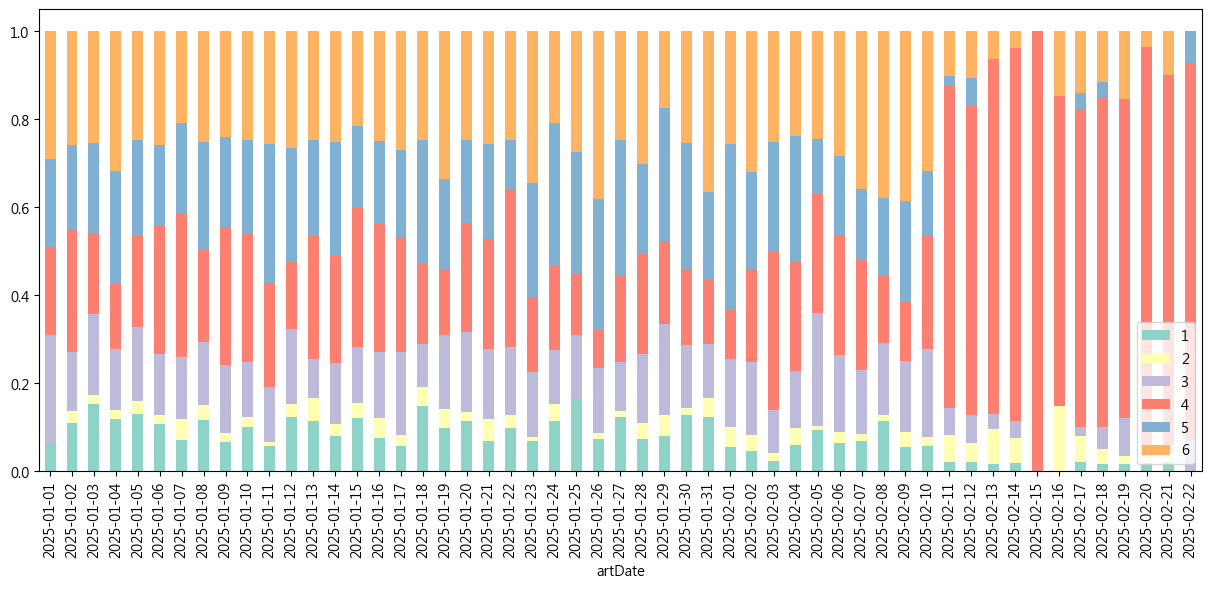

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

我們觀察其中Label 6（橘色）：
- 1月初至2月初（2025-01-01～2025-02-08）：橘色主題（Label 6）占比穩定且明顯，幾乎每一天都佔整體的 20%～30%。
- 2月9日後（特別是2/10～2/20）：橘色占比急遽下降，在 2/13～2/19 甚至幾乎完全消失，直到 2/20 才稍微回升。表示該主題在這段時間被其他主題壓過（例如紅色的 Label 4），使用者焦點從 Label 6 轉移開來。

C:\Users\user\AppData\Local\Temp\ipykernel_15792\82803260.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['artDate'] = pd.to_datetime(test['artDate'])


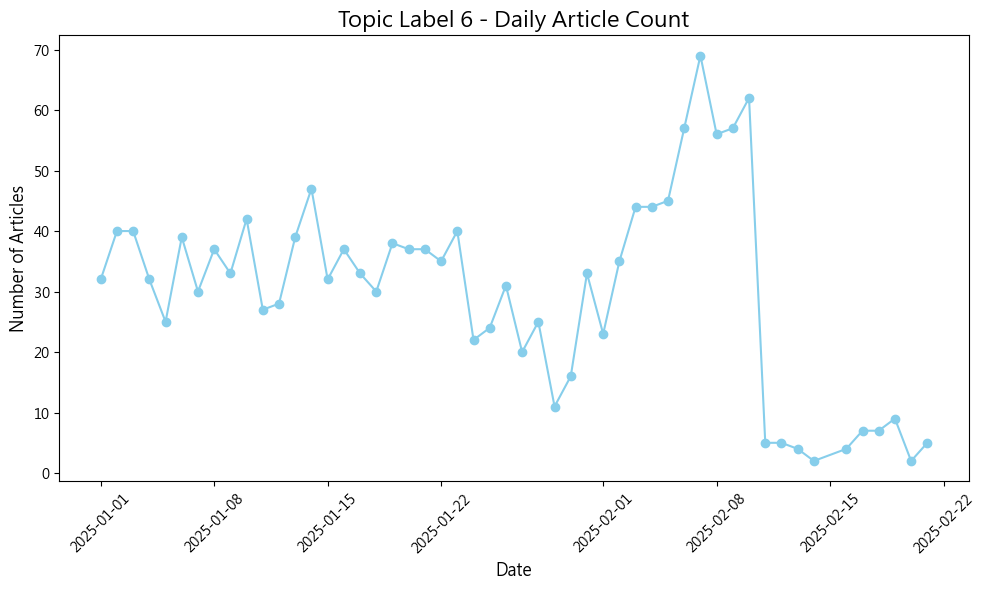

In [ ]:
import matplotlib.pyplot as plt

# 篩選出 topic_label == 6 的文章
test = dcard[dcard['topic_label'] == 6]

# 確保 'artDate' 是 datetime 格式
test['artDate'] = pd.to_datetime(test['artDate'])

# 按天分組，計算每天的文章數量
daily_counts = test.groupby(test['artDate'].dt.date).size()

# 畫線圖
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='line', color='skyblue', marker='o')

# 添加標題和標籤
plt.title('Topic Label 6 - Daily Article Count', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

# 顯示 x 軸的日期標籤
plt.xticks(rotation=45)

# 顯示圖表
plt.tight_layout()  # 自動調整排版，避免文字重疊
plt.show()

從圖中可以清楚看出：
- 1月整體狀況穩定：從 1 月初到 1 月底，Label 6 每天的貼文數大多維持在 30~45 篇之間，顯示該主題是這段期間相當活躍的討論內容。
- 2月初有一波明顯上升：進入 2 月後，文章數快速上升，尤其在 2 月 5 日到 2 月 9 日期間達到高峰，單日貼文數一度逼近 70 篇，代表這個主題在當時引起大量討論。
- 2月10日之後急遽下降：到了 2 月 10 日之後，貼文數量突然大幅下滑，從將近 60~70 篇掉到只剩個位數。這種劇烈的變化說明用戶在那段時間轉移了關注焦點。

## 了解該主題 Label 6下的貼文類型分布

In [ ]:
dcard_lable_6["artCatagory"].value_counts()

artCatagory
graduate_school    1397
stock               105
food                 32
Name: count, dtype: int64


![圖片描述](https://i.imgur.com/F6W67Oo.png)

source: 大碩研究所補習班

從前面的折線圖可以看到，Label 6 的文章數在 2 月初快速上升，並在 2/7~2/9 之間達到高峰，隨後在 2/10 開始劇烈下降。

根據上圖這張 2024 年研究所筆試日程表，2 月 1 日至 2 月 9 日之間，正是多所熱門學校筆試集中舉辦的時段，包括：

2/1：成大、清大 2/2：台大 2/5：政大 2/6：合科大 2/7：中山 2/8：中興

對應到在 Label 6 主題中觀察到的大量貼文暴增現象。

貼文數驟降原因？
當筆試高峰期一結束（2/9 後），學生不再密集發文問問題或討論考題，導致 Label 6 的貼文數在 2/10 起迅速下滑。

我們會特別針對 Label 6 這個主題做情緒分析，主要是因為它與升學相關、尤其是研究所筆試等內容密切相關，而這類議題往往會引起使用者在貼文中展現出各種情緒反應。
希望透過進一步的分析，觀察在這些升學相關討論中，是否可以看出某些共同的情緒特徵，或是根據不同事件（如考前、考後）而有所變化。
換句話說，我們想了解的是：在這類壓力情境下，使用者的貼文情緒是偏向緊張、煩躁，還是反而出現鼓勵、期待、分享等正向內容，進而對這段期間的情緒氛圍有更完整的理解。

#### 結合情緒分類
針對主題6作正負向情緒分析，抓取topic_label=6 的文章

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [ ]:
dcard_lable_6 = dcard_lable_6.explode("words").rename(columns={"words": "word"})

In [ ]:
dcard_liwc_df = pd.merge(dcard_lable_6[["artUrl", "artDate", "content", "word"]], liwc_dict, how="left")
dcard_liwc_df.head()

,artUrl,artDate,content,word,sentiments
0,https://www.dcard.tw/f/stock/p/257762652,2025-01-15 13:00:35,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,標的,NaN
1,https://www.dcard.tw/f/stock/p/257762652,2025-01-15 13:00:35,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,台指,NaN
2,https://www.dcard.tw/f/stock/p/257762652,2025-01-15 13:00:35,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,期貨,NaN
3,https://www.dcard.tw/f/stock/p/257762652,2025-01-15 13:00:35,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,選擇權,NaN
4,https://www.dcard.tw/f/stock/p/257762652,2025-01-15 13:00:35,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,多空,NaN


In [ ]:
sentiment_count = pd.DataFrame(
    dcard_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
1,2025-01-01 02:00:58,positive,4
3,2025-01-01 03:19:28,positive,1
5,2025-01-01 04:16:16,positive,2
7,2025-01-01 04:16:26,positive,6
9,2025-01-01 05:12:59,negative,4
...,...,...,...
3462,2025-02-21 03:04:51,negative,2
3463,2025-02-21 03:04:51,positive,3
3466,2025-02-21 05:51:14,negative,1
3467,2025-02-21 05:51:14,positive,5


#### 正負向情緒詞彙頻率折線圖圖

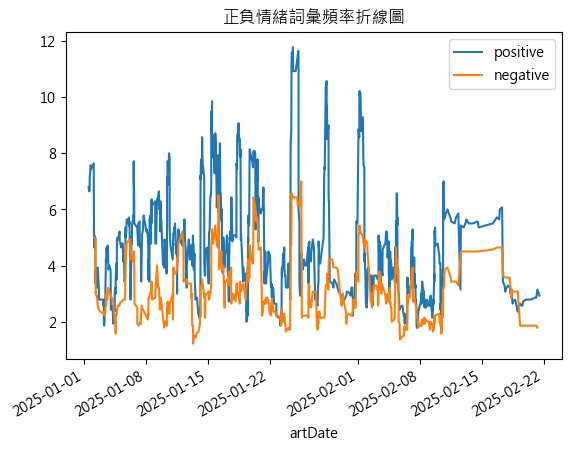

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")
plt.show()

In [ ]:
# 與 apply 不同，transform 返回的結果與原數據的形狀一致。
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

,artDate,sentiments,size,ratio
1,2025-01-01 02:00:58,positive,4,1.000000
3,2025-01-01 03:19:28,positive,1,1.000000
5,2025-01-01 04:16:16,positive,2,1.000000
7,2025-01-01 04:16:26,positive,6,1.000000
9,2025-01-01 05:12:59,negative,4,0.307692
10,2025-01-01 05:12:59,positive,9,0.692308
13,2025-01-01 05:29:56,positive,3,1.000000
15,2025-01-01 08:48:55,negative,3,0.300000
16,2025-01-01 08:48:55,positive,7,0.700000
20,2025-01-01 09:39:40,negative,27,0.385714


In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

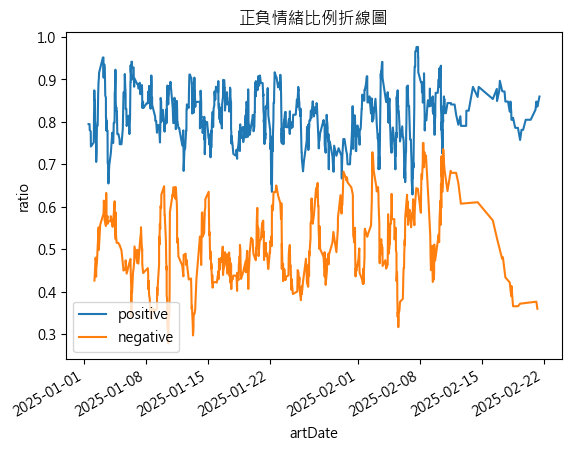

In [ ]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

#### 文章為單位的情緒分析

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    dcard_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,sentiments,size
0,https://www.dcard.tw/f/food/p/257645541,affect,1
1,https://www.dcard.tw/f/food/p/257645541,positive,1
2,https://www.dcard.tw/f/food/p/257680392,affect,5
3,https://www.dcard.tw/f/food/p/257680392,positive,5
4,https://www.dcard.tw/f/food/p/257686921,affect,3
5,https://www.dcard.tw/f/food/p/257686921,negative,1
6,https://www.dcard.tw/f/food/p/257686921,positive,2
7,https://www.dcard.tw/f/food/p/257708165,affect,10
8,https://www.dcard.tw/f/food/p/257708165,positive,10
9,https://www.dcard.tw/f/food/p/257738855,affect,1


In [ ]:
dcard_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
dcard_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.dcard.tw/f/food/p/257645541,1.0,0.0,0.0,0.0,1.0,0.0
1,https://www.dcard.tw/f/food/p/257680392,5.0,0.0,0.0,0.0,5.0,0.0
2,https://www.dcard.tw/f/food/p/257686921,3.0,0.0,0.0,1.0,2.0,0.0
3,https://www.dcard.tw/f/food/p/257708165,10.0,0.0,0.0,0.0,10.0,0.0
4,https://www.dcard.tw/f/food/p/257738855,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# sentiment 計算方式: positive - negative
dcard_sentiment_value_by_article["sentiment_value"] = (
    dcard_sentiment_value_by_article["positive"]
    - dcard_sentiment_value_by_article["negative"]
)
dcard_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.dcard.tw/f/food/p/257645541,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,https://www.dcard.tw/f/food/p/257680392,5.0,0.0,0.0,0.0,5.0,0.0,5.0
2,https://www.dcard.tw/f/food/p/257686921,3.0,0.0,0.0,1.0,2.0,0.0,1.0
3,https://www.dcard.tw/f/food/p/257708165,10.0,0.0,0.0,0.0,10.0,0.0,10.0
4,https://www.dcard.tw/f/food/p/257738855,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
dcard_sentiment_value_by_article['sentiment_class'] = dcard_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
dcard_sentiment_value_by_article.head(10)

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.dcard.tw/f/food/p/257645541,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
1,https://www.dcard.tw/f/food/p/257680392,5.0,0.0,0.0,0.0,5.0,0.0,5.0,正向
2,https://www.dcard.tw/f/food/p/257686921,3.0,0.0,0.0,1.0,2.0,0.0,1.0,正向
3,https://www.dcard.tw/f/food/p/257708165,10.0,0.0,0.0,0.0,10.0,0.0,10.0,正向
4,https://www.dcard.tw/f/food/p/257738855,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
5,https://www.dcard.tw/f/food/p/257742630,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
6,https://www.dcard.tw/f/food/p/257744112,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
7,https://www.dcard.tw/f/food/p/257750602,14.0,0.0,0.0,0.0,13.0,0.0,13.0,正向
8,https://www.dcard.tw/f/food/p/257752146,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
9,https://www.dcard.tw/f/food/p/257756557,23.0,4.0,0.0,12.0,11.0,1.0,-1.0,負向


In [ ]:
clear_df_sentiment = pd.merge(dcard_lable_6, dcard_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

,content,artUrl,artCatagory,artDate,word,topic_label,sentiment_class
0,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,https://www.dcard.tw/f/stock/p/257762652,stock,2025-01-15,標的,6,NaN
1,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,https://www.dcard.tw/f/stock/p/257762652,stock,2025-01-15,台指,6,NaN
2,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,https://www.dcard.tw/f/stock/p/257762652,stock,2025-01-15,期貨,6,NaN
3,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,https://www.dcard.tw/f/stock/p/257762652,stock,2025-01-15,選擇權,6,NaN
4,標的台指期貨選擇權多空未平倉合約口數葡萄可樂口葡萄比可樂多口月期貨選擇權做空的散戶比較多新開...,https://www.dcard.tw/f/stock/p/257762652,stock,2025-01-15,多空,6,NaN


In [ ]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2025-01-01,正向,2406
1,2025-01-01,負向,194
2,2025-01-02,正向,1932
3,2025-01-02,負向,339
4,2025-01-03,正向,1867
...,...,...,...
89,2025-02-18,正向,223
90,2025-02-18,負向,81
91,2025-02-19,正向,294
92,2025-02-20,正向,19


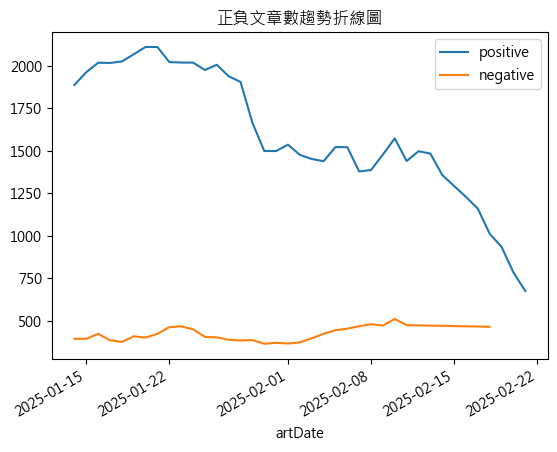

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

#### 2025-02-08 ~2025-02-20 文字雲
查看2025-02-08 ~2025-02-20 這段時間出現了什麼關鍵字

In [ ]:
date = "2025-02-08"
end_date = "2025-02-20"
mask = (clear_df_sentiment['artDate'] >= pd.Timestamp(date).date()) & (
    clear_df_sentiment['artDate'] <= pd.Timestamp(end_date).date()) & (
    clear_df_sentiment['sentiment_class'] == "負向")

ptt_df_wc = clear_df_sentiment.loc[mask]
ptt_df_wc.head(10)

,content,artUrl,artCatagory,artDate,word,topic_label,sentiment_class
2741,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,投資,6,負向
2742,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,詐騙,6,負向
2743,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,小心,6,負向
2744,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,名人,6,負向
2745,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,出書,6,負向
2746,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,被盜,6,負向
2747,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,加進去,6,負向
2748,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,勢如破竹,6,負向
2749,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,投資,6,負向
2750,其他投資詐騙大家小心這個名人有出書也被盜用了加進去就到勢如破竹的投資詐騙群了目前群還存在繼續...,https://www.dcard.tw/f/stock/p/257961917,stock,2025-02-11,詐騙,6,負向


In [ ]:
#clear_df_sentiment_wc = clear_df_sentiment.explode("words").rename(columns={"words": "word"})
#clear_df_sentiment_wc.head(3)
clear_df_sentiment_wc = ptt_df_wc

In [ ]:
date = "2025-02-08"
end_date = "2025-02-20"
mask = (clear_df_sentiment_wc['artDate'] >= pd.Timestamp(date).date()) & (
    clear_df_sentiment_wc['artDate'] <= pd.Timestamp(end_date).date()) & (
    clear_df_sentiment_wc['sentiment_class'] == "負向")

dcard_df_wc = clear_df_sentiment_wc.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    dcard_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

,word,size
460,教授,18
907,面試,16
52,中興,14
598,目前,14
620,研究所,13
709,考試,13
216,問題,12
301,學長,12
214,問卷,11
540,比較,10


(-0.5, 1599.5, 799.5, -0.5)

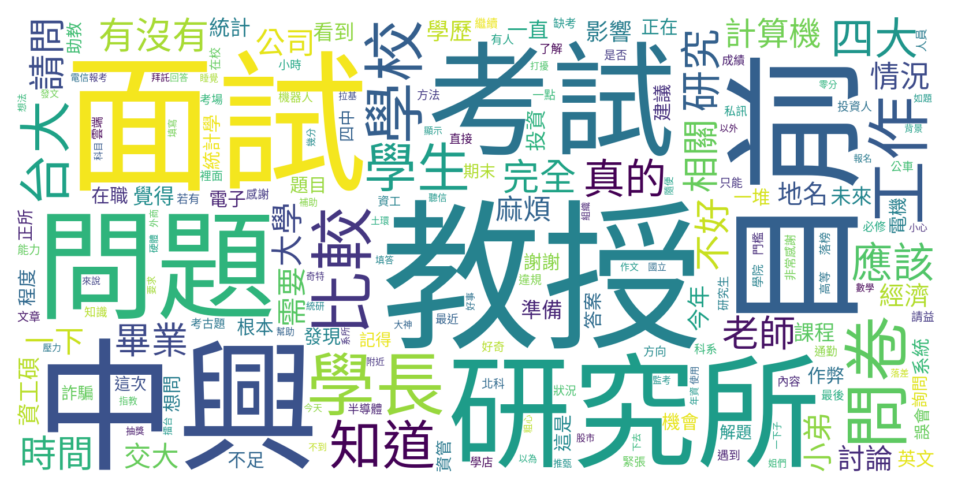

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = './raw_data/SourceHanSansTW-Regular.otf' # 設定字型
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

In [ ]:
date = "2025-02-08"
end_date = "2025-02-20"
mask = (clear_df_sentiment['artDate'] >= pd.Timestamp(date).date()) & (
    clear_df_sentiment['artDate'] <= pd.Timestamp(end_date).date()) & (
    clear_df_sentiment['sentiment_class'] == "正向")

ptt_df_wc = clear_df_sentiment.loc[mask]
ptt_df_wc.head(10)

,content,artUrl,artCatagory,artDate,word,topic_label,sentiment_class
2523,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,分享,6,正向
2524,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,小王子,6,正向
2525,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,上課,6,正向
2526,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,績效,6,正向
2527,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,有人,6,正向
2528,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,過後,6,正向
2529,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,實戰,6,正向
2530,分享還有人在小王子上課後的績效嗎有人上過後實戰後的心得嗎,https://www.dcard.tw/f/stock/p/257934170,stock,2025-02-08,心得,6,正向
2531,分享有人要加群組一起學習股票嗎群組限額開放啦原本群組的大神只開放認識的人加入後來認識更多有在...,https://www.dcard.tw/f/stock/p/257954051,stock,2025-02-10,分享,6,正向
2532,分享有人要加群組一起學習股票嗎群組限額開放啦原本群組的大神只開放認識的人加入後來認識更多有在...,https://www.dcard.tw/f/stock/p/257954051,stock,2025-02-10,有人,6,正向


In [ ]:
clear_df_sentiment_wc = ptt_df_wc

In [ ]:
date = "2025-02-08"
end_date = "2025-02-20"
mask = (clear_df_sentiment_wc['artDate'] >= pd.Timestamp(date).date()) & (
    clear_df_sentiment_wc['artDate'] <= pd.Timestamp(end_date).date()) & (
    clear_df_sentiment_wc['sentiment_class'] == "正向")

dcard_df_wc = clear_df_sentiment_wc.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    dcard_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

,word,size
2124,群組,83
387,分享,78
1914,研究,71
2648,開放,56
1343,教授,48
432,加入,47
1863,目前,46
2149,考試,44
1499,朋友,43
590,問卷,42


(-0.5, 1599.5, 799.5, -0.5)

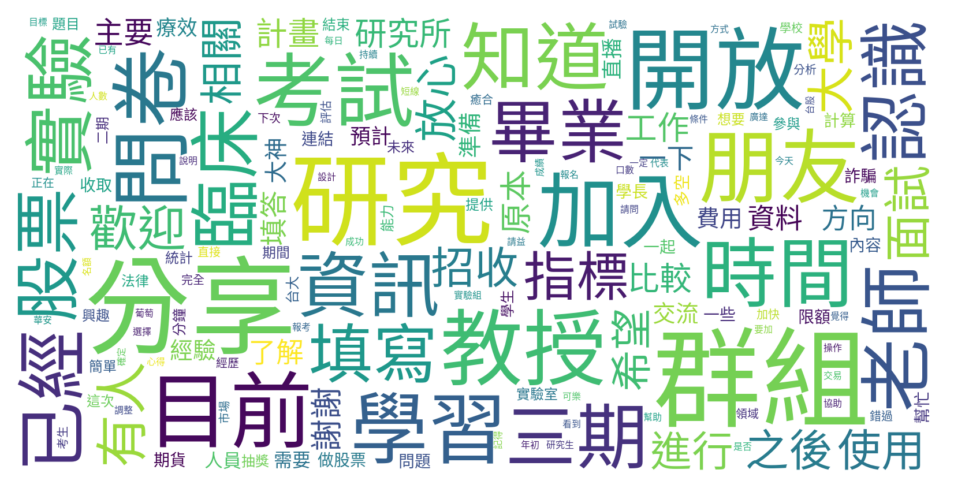

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

- 負面情緒:主要集中在升學壓力與準備研究所筆試相關議題。「教授」、「面試」、「問題」、「作業」等詞語，顯示學生對於準備研究所的過程感到壓力大、焦慮
- 正面情緒:較偏向新階段的期待與機會，如「開放」、「加入」、「學習」、「朋友」

從文章的內容可以發現，雖然前面有「股價跟漲」等股票相關的字眼，但後面的內容多跟「高鐵便當」、「原物料」等美食相關的字眼。